### Federated Learning of the simple CNN model as **FL-SimpCNN** using fedAvg

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-06-10 20:29:34.315014: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 20:29:34.346513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 20:29:34.346540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 20:29:34.346563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 20:29:34.352700: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tqdm.notebook import tqdm
import time
#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time
import numpy as np
IMAGE_SIZE = 200

### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

####  Loading NumPy Array Datasets:

In [ ]:
# # # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_data_x_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_input.npy')
#output_label_y_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_output.npy')

#Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


##### Data used to train teacher models for each client

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


## Federated Learning Datasets

In [ ]:
def dataset_pixel_stat(dataset):
    mean_pixel_value = np.mean(dataset)
    variance_pixel_value = np.var(dataset)
    std_dev_pixel_value = np.std(dataset)
    # Display the computed statistics
    print("Mean Pixel Value:", mean_pixel_value)
    print("Variance of Pixel Values:", variance_pixel_value)
    print("Standard Deviation of Pixel Values:", std_dev_pixel_value)

    # Compute histograms of pixel values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Values (Entire Dataset)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Assuming you have subsets 'subset1' and 'subset2' of the dataset
    # Compute histograms for each subset
    plt.subplot(1, 2, 2)
    plt.hist(dataset[0:500,:].flatten(), bins=50, color='red', alpha=0.7, label='Subset 1')
    plt.hist(dataset[501:1000,:].flatten(), bins=50, color='green', alpha=0.7, label='Subset 2')
    plt.hist(dataset[1001:1500,:].flatten(), bins=50, color='yellow', alpha=0.7, label='Subset 3')

    plt.title('Histogram of Pixel Values (Subsets)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

In [ ]:
print('------ Federated Training----------')
train_features_dataset1_fed, test_features_dataset1_fed, train_labels_dataset1_fed, test_labels_dataset1_fed = train_test_split(
    input_data_x_load[2501:3901,:], output_label_y_load[2501:3901,:], test_size=.20, random_state=25)
train_features_dataset2_fed, test_features_dataset2_fed, train_labels_dataset2_fed, test_labels_dataset2_fed = train_test_split(
    input_data_x_2_load[6501:10400,:], output_label_y_2_load[6501:10400,:], test_size=.20, random_state=25)
train_features_dataset3_fed, test_features_dataset3_fed, train_labels_dataset3_fed, test_labels_dataset3_fed = train_test_split(
    input_data_x_3_load[1201:,:], output_label_y_3_load[1201:,:], test_size=.20, random_state=25)
print('client 1 federated dataset: ', train_features_dataset1_fed.shape, test_features_dataset1_fed.shape, train_labels_dataset1_fed.shape, test_labels_dataset1_fed.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed.shape, test_features_dataset2_fed.shape, train_labels_dataset2_fed.shape, test_labels_dataset2_fed.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed.shape, test_features_dataset3_fed.shape, train_labels_dataset3_fed.shape, test_labels_dataset3_fed.shape)


------ Federated Training----------
client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


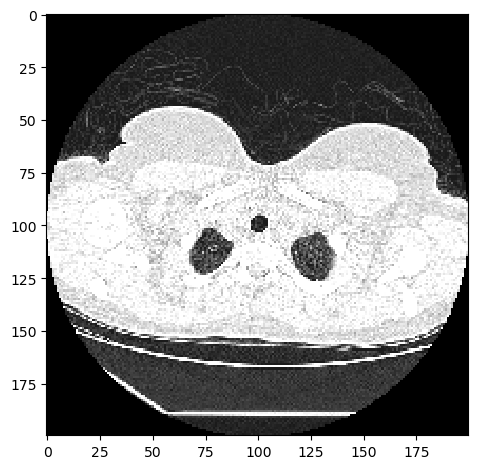

---------------Client 2 sample Image -----------------


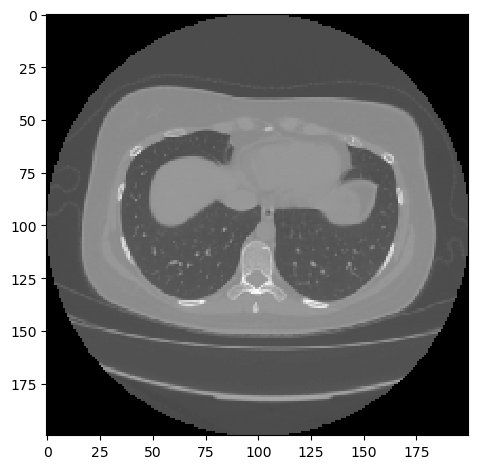

---------------Client 3 sample Image -----------------


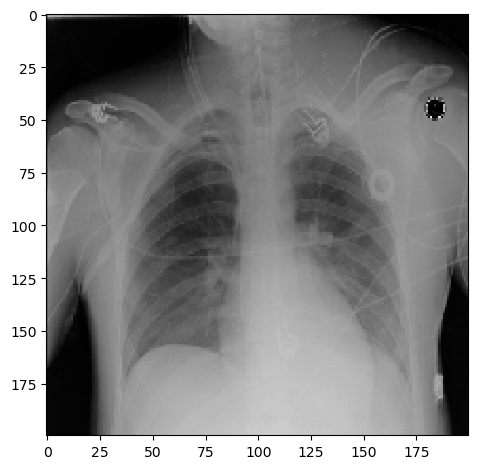

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed[0])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed[100])
show()

In [ ]:
print('--------------------- Testing dataset--------------')
# Assuming client_images and client_labels are numpy arrays or lists of numpy arrays
X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
                                  test_features_dataset3_fed), axis=0)
y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
                                  test_labels_dataset3_fed), axis=0)

--------------------- Testing dataset--------------


### Preparing The Federated Dataset (non_iid Dataset )

Mean Pixel Value: 0.5149437324054628
Variance of Pixel Values: 0.13384306055452233
Standard Deviation of Pixel Values: 0.36584567860577816


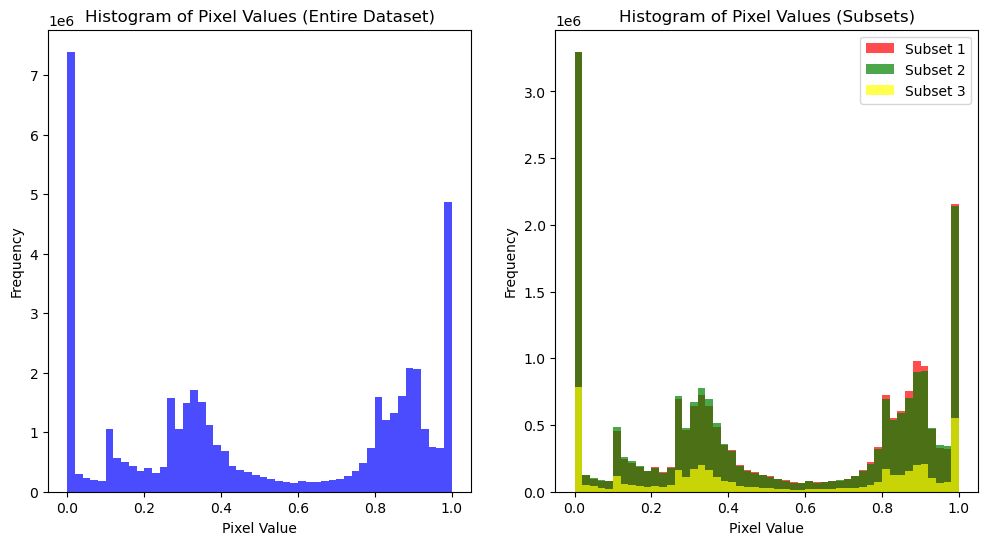

Mean Pixel Value: 0.2761424951121855
Variance of Pixel Values: 0.056925370933381306
Standard Deviation of Pixel Values: 0.23859038315359926


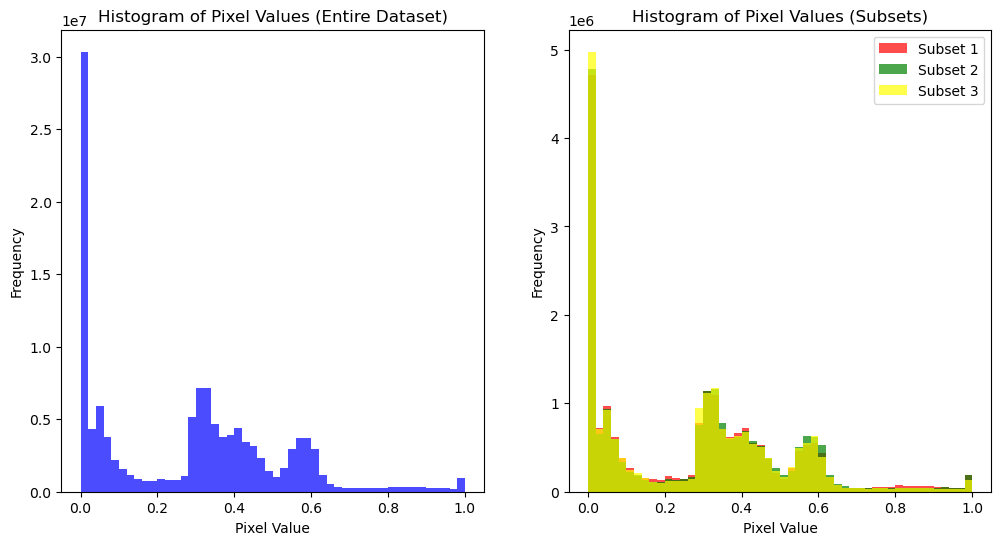

Mean Pixel Value: 0.5393774509803901
Variance of Pixel Values: 0.07674632723644069
Standard Deviation of Pixel Values: 0.2770312748345224


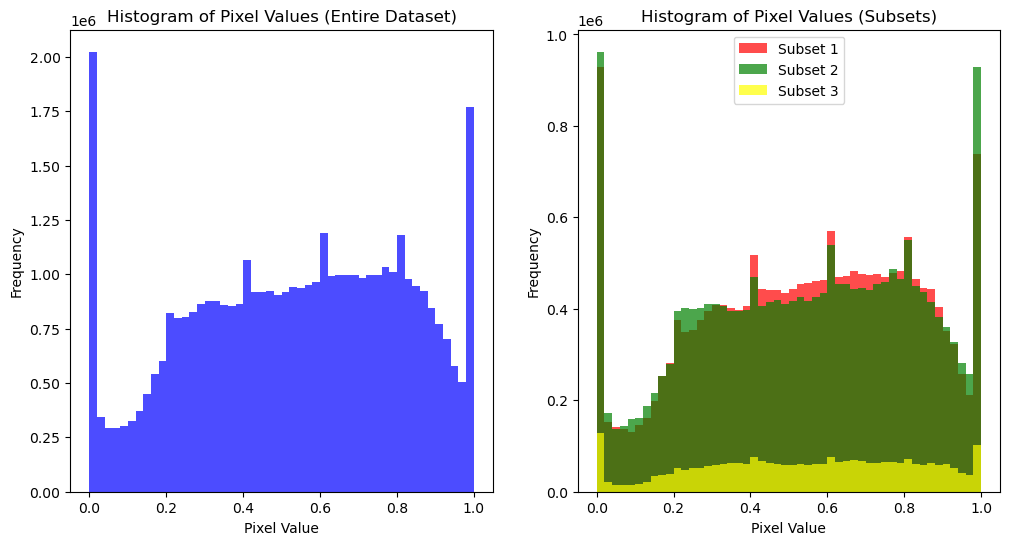

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed)
dataset_pixel_stat(train_features_dataset2_fed)
dataset_pixel_stat(train_features_dataset3_fed)

###### non-iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed, train_labels_dataset2_fed),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]#(train_features_dataset3_fed, train_labels_dataset3_fed)

NUM_CLIENTS = len(client_data)  # Number of clients
BATCH_SIZE = 20

def create_tf_dataset_for_client(client_dataset):
    """Create a tf.data.Dataset object for a client's data."""
    client_images, client_labels = client_dataset
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    return dataset

client_datasets = [create_tf_dataset_for_client(data) for data in client_data]

def preprocess_dataset(dataset, batch_size=BATCH_SIZE , shuffle_buffer_size=100):
    """Preprocess the dataset."""
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#federated_clients
fed_clients = ['client_'+str(i) for i in range(1,NUM_CLIENTS+1)]

# Federated data preparation
federated_train_data_nonIID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid Unbalanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid Unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### non-iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed[0:1200,:], train_labels_dataset2_fed[0:1200,:]),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_nonIID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid balanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Preparing The Federated Dataset (iid Dataset )

In [ ]:
train_features_dataset1_fed_iid, test_features_dataset1_fed_iid, train_labels_dataset1_fed_iid, test_labels_dataset1_fed_iid = train_test_split(
    input_data_x_2_load[6501:7901,:], output_label_y_2_load[6501:7901,:], test_size=.20, random_state=42)
train_features_dataset2_fed_iid, test_features_dataset2_fed_iid, train_labels_dataset2_fed_iid, test_labels_dataset2_fed_iid = train_test_split(
    input_data_x_2_load[7901:11800,:], output_label_y_2_load[7901:11800,:], test_size=.20, random_state=42)
train_features_dataset3_fed_iid, test_features_dataset3_fed_iid, train_labels_dataset3_fed_iid, test_labels_dataset3_fed_iid = train_test_split(
    input_data_x_2_load[11800:13139,:], output_label_y_2_load[11800:13139,:], test_size=.20, random_state=42)
print('client 1 federated dataset: ', train_features_dataset1_fed_iid.shape, test_features_dataset1_fed_iid.shape, train_labels_dataset1_fed_iid.shape, test_labels_dataset1_fed_iid.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed_iid.shape, test_features_dataset2_fed_iid.shape, train_labels_dataset2_fed_iid.shape, test_labels_dataset2_fed_iid.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed_iid.shape, test_features_dataset3_fed_iid.shape, train_labels_dataset3_fed_iid.shape, test_labels_dataset3_fed_iid.shape)

client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


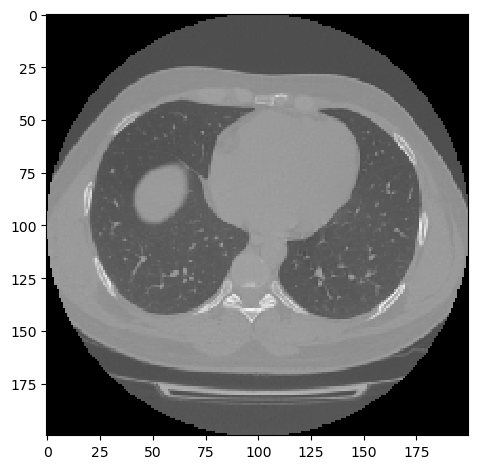

---------------Client 2 sample Image -----------------


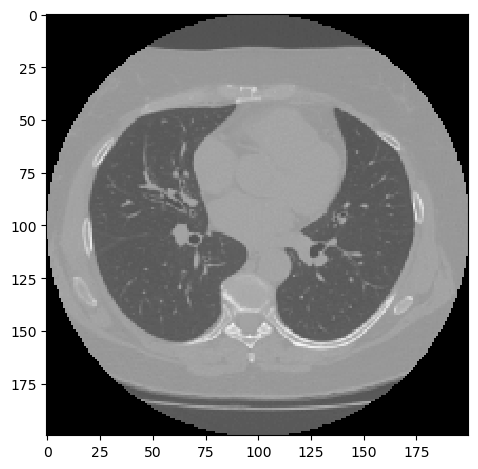

---------------Client 3 sample Image -----------------


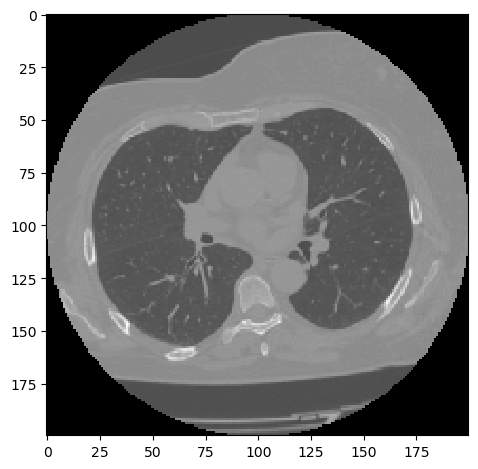

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed_iid[100])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed_iid[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed_iid[0])
show()

Mean Pixel Value: 0.27787371095938374
Variance of Pixel Values: 0.0582723553891214
Standard Deviation of Pixel Values: 0.24139667642517657


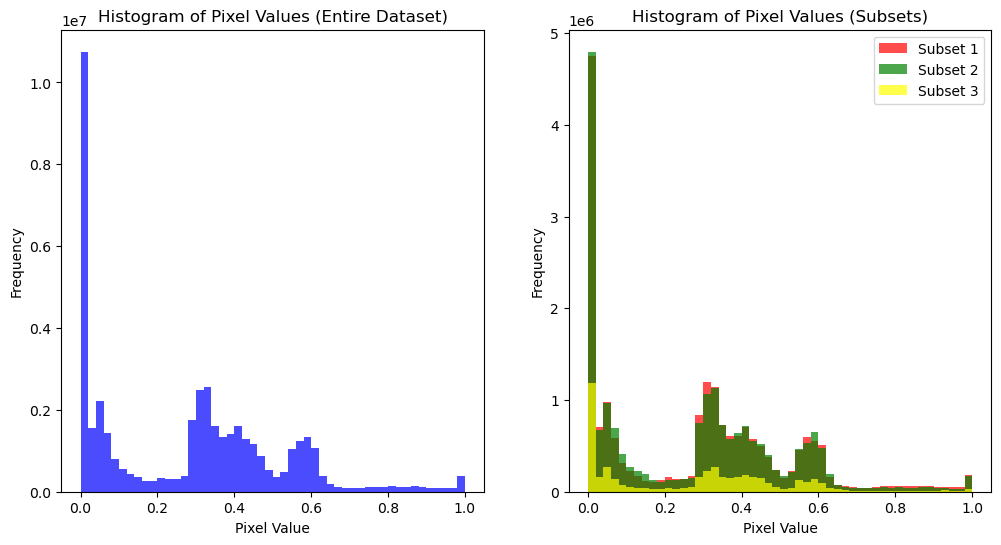

Mean Pixel Value: 0.27760929562014075
Variance of Pixel Values: 0.056485812467578035
Standard Deviation of Pixel Values: 0.2376674409076221


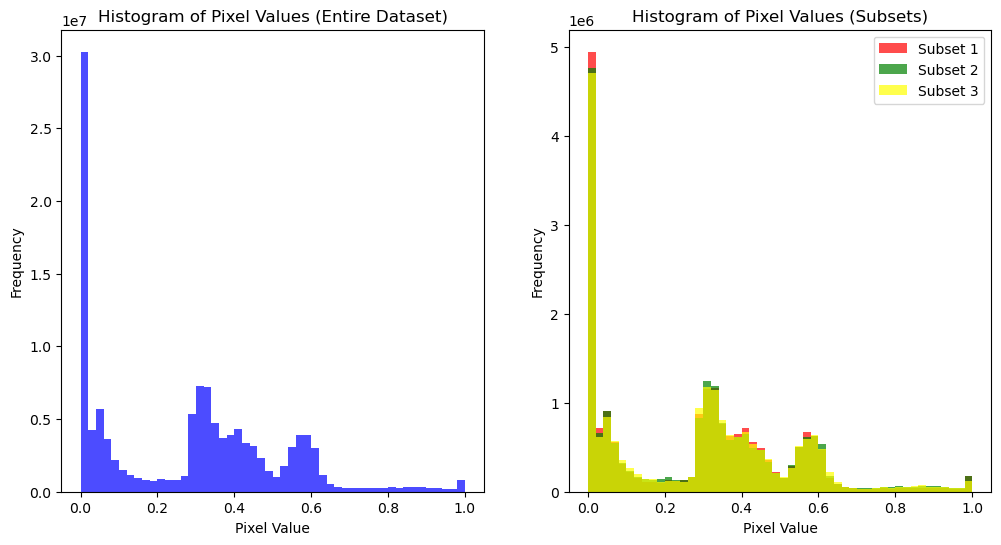

Mean Pixel Value: 0.2768275683345227
Variance of Pixel Values: 0.05673954491991269
Standard Deviation of Pixel Values: 0.23820064004933464


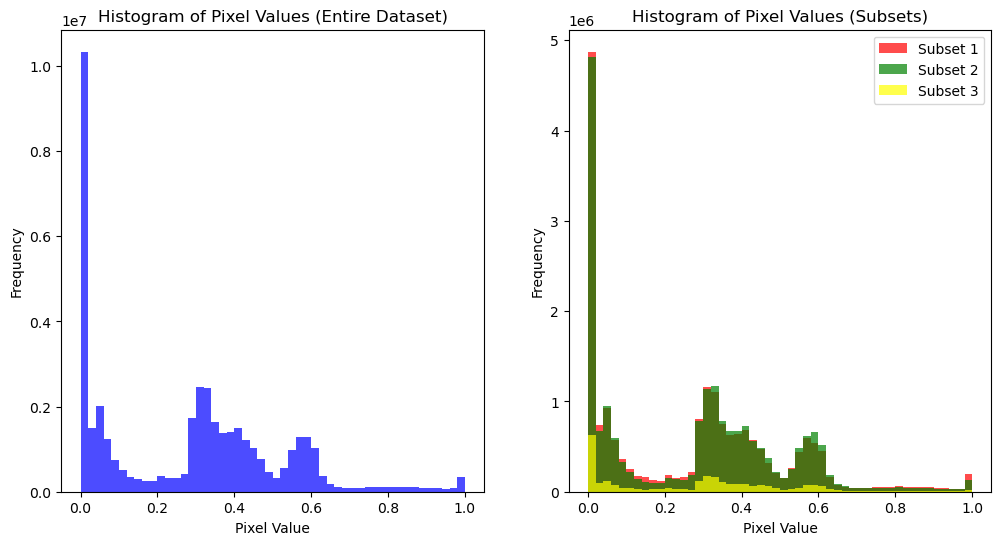

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed_iid)
dataset_pixel_stat(train_features_dataset2_fed_iid)
dataset_pixel_stat(train_features_dataset3_fed_iid)

###### iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid unbalanced Dataset Data type: ', type(federated_train_data_IID_unbalanced))
print('Length: ', len(federated_train_data_IID_unbalanced))

Fedrated iid unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid[0:1200,:], train_labels_dataset2_fed_iid[0:1200,:]),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
print('Length: ', len(federated_train_data_IID_balanced))

Fedrated iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Federated Learning

In [ ]:
def create_SimpCNN():#this is student model
    initializer = tf.keras.initializers.GlorotNormal(seed=0)
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),#### Added this march 6 2024
      tf.keras.layers.Dense(2, kernel_initializer=initializer),
      tf.keras.layers.Softmax(),
    ])

def model_fn(initial_weights=None):
    keras_model = create_SimpCNN()
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_IID_balanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    """Performs local training on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)
    # Initialize the client optimizer.
    trainable_tensor_specs = tf.nest.map_structure(
          lambda v: tf.TensorSpec(v.shape, v.dtype), client_weights)
    optimizer_state = client_optimizer.initialize(trainable_tensor_specs)
    # Use the client_optimizer to update the local model.
    for batch in iter(dataset):
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data.
            outputs = model.forward_pass(batch)
        # Compute the corresponding gradient.
        grads = tape.gradient(outputs.loss, client_weights)
        # Apply the gradient using a client optimizer.
        optimizer_state, updated_weights = client_optimizer.next(
            optimizer_state, client_weights, grads)
        tf.nest.map_structure(lambda a, b: a.assign(b),
                              client_weights, updated_weights)
    # Return model deltas.
    return tf.nest.map_structure(tf.subtract, client_weights, server_weights)

In [ ]:
import attrs
from typing import Any
import functools
@attrs.define(eq=False, frozen=True)
class ServerState(object):
    trainable_weights: Any
    optimizer_state: Any

@tf.function
def server_update(server_state, mean_model_delta, server_optimizer):
    """Updates the server model weights."""
    # Use aggregated negative model delta as pseudo gradient.
    negative_weights_delta = tf.nest.map_structure(
      lambda w: -1.0 * w, mean_model_delta)
    new_optimizer_state, updated_weights = server_optimizer.next(
      server_state.optimizer_state, server_state.trainable_weights,
      negative_weights_delta)
    return tff.structure.update_struct(
      server_state,
      trainable_weights=updated_weights,
      optimizer_state=new_optimizer_state)

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.05, momentum=0.8)
client_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.0001)


In [ ]:
# 2. Functions return initial state on server.
@tff.tf_computation
def server_init():
    model = model_fn()
    trainable_tensor_specs = tf.nest.map_structure(
        lambda v: tf.TensorSpec(v.shape, v.dtype), model.trainable_variables)
    optimizer_state = server_optimizer.initialize(trainable_tensor_specs)
    return ServerState(
      trainable_weights=model.trainable_variables,
      optimizer_state=optimizer_state)
@tff.federated_computation
def server_init_tff():
    return tff.federated_value(server_init(), tff.SERVER)

/tmp/ipykernel_217847/591050228.py:3: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  def server_init():


In [ ]:
# 3. One round of computation and communication.
server_state_type = server_init.type_signature.result
print('server_state_type:\n',
      server_state_type.formatted_representation())
trainable_weights_type = server_state_type.trainable_weights
print('trainable_weights_type:\n',
      trainable_weights_type.formatted_representation())

server_state_type:
 <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >
  >
>
trainable_weights_type:
 <
  float32[3,3,1,32],
  float32[32],
  float32[313632,2],
  float32[2]
>


In [ ]:
# 3-1. Wrap server and client TF blocks with `tff.tf_computation`.
@tff.tf_computation(server_state_type, trainable_weights_type)
def server_update_fn(server_state, model_delta):
    return server_update(server_state, model_delta, server_optimizer)

/tmp/ipykernel_217847/2044740559.py:2: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(server_state_type, trainable_weights_type)


In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(whimsy_model.input_spec))
print('tf_dataset_type:\n',
      tf_dataset_type.formatted_representation())

@tff.tf_computation(tf_dataset_type, trainable_weights_type)
def client_update_fn(dataset, server_weights):
    model = model_fn()
    return client_update(model, dataset, server_weights, client_optimizer)

tf_dataset_type:
 <
  float64[?,200,200,1],
  uint8[?,2]
>*


/tmp/ipykernel_217847/3793503675.py:6: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(tf_dataset_type, trainable_weights_type)


In [ ]:
# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
@tff.federated_computation(federated_server_type, federated_dataset_type)
def run_one_round(server_state, federated_dataset):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

In [ ]:
# 4. Build the iterative process for FedAvg.
fedavg_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      fedavg_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      fedavg_process.next.type_signature.formatted_representation())

type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >,
    optimizer_state=<
      learning_rate=float32,
      momentum=float32,
      accumulator=<
        float32[3,3,1,32],
        float32[32],
        float32[313632,2],
        float32[2]
      >
    >
  >@SERVER,
  federated_dataset={<
    float64[?,200,200,1],
    uint8[?,2]
  >*}@CLIENTS
> -> <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      

### Evaluating the algorithm

https://www.tensorflow.org/federated/tutorials/custom_federated_algorithm_with_tff_optimizers#evaluating_the_algorithm

In [ ]:
def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

In [ ]:
def evaluate(server_state, dataset):
    keras_model = create_SimpCNN()
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    keras_model.set_weights(server_state.trainable_weights)
    keras_model.evaluate(dataset)
    return keras_model

server_state = fedavg_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)

2024-06-11 02:42:07.842126: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-11 02:42:07.842466: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-11 02:42:07.847660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-11 02:42:07.848010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-11 02:42:07.848334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 3s 18ms/step - loss: 0.7012 - categorical_accuracy: 0.4834


9/9 [==============================] - 0s 25ms/step


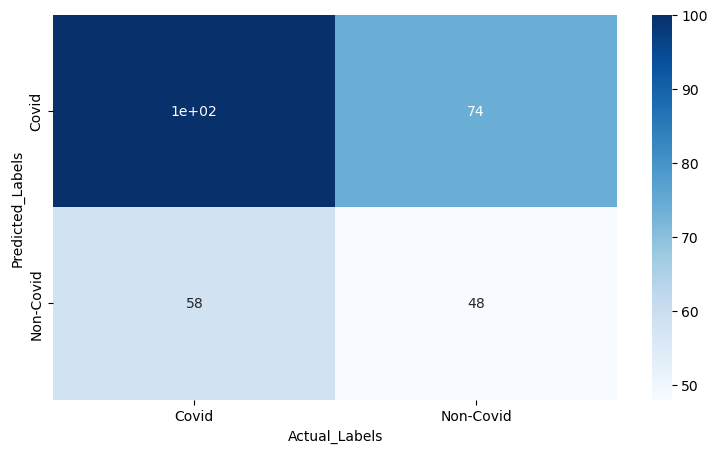

test accuracy = 52.85714285714286%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5286
Precision: 0.5216
Recall: 0.5286
F1 Score: 0.5234
25/25 [==============================] - 1s 31ms/step


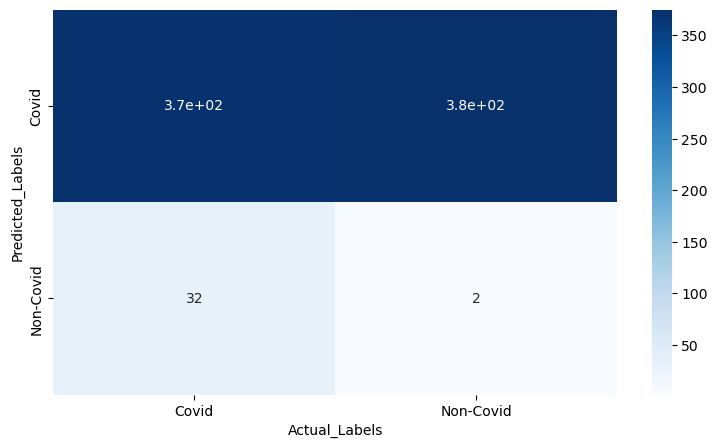

test accuracy = 47.820512820512825%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4782
Precision: 0.2854
Recall: 0.4782
F1 Score: 0.3384
9/9 [==============================] - 0s 30ms/step


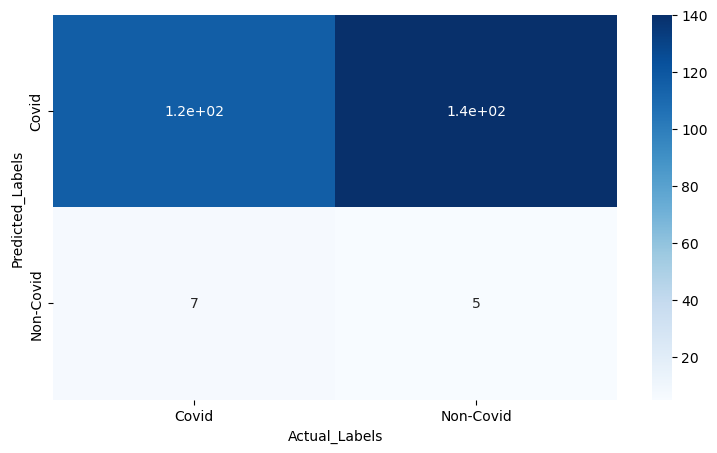

test accuracy = 45.149253731343286%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4515
Precision: 0.4334
Recall: 0.4515
F1 Score: 0.3154


In [ ]:
# X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
#                                   test_features_dataset3_fed), axis=0)
# y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
#                                   test_labels_dataset3_fed), axis=0)
getModelEvaluation(student_inital_model,test_features_dataset1_fed,test_labels_dataset1_fed)
getModelEvaluation(student_inital_model,test_features_dataset2_fed,test_labels_dataset2_fed)
getModelEvaluation(student_inital_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
metrics = {'loss':[],'accuracy':[]}

## FedAvg (FL-SimpCNN) Experiments

- federated_train_data_nonIID_unbalanced
- federated_train_data_nonIID_balanced
- federated_train_data_IID_unbalanced
- federated_train_data_IID_balanced

### federated_train_data_nonIID_unbalanced

In [ ]:
from tqdm import tqdm
import time
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_unbalanced)
    FL-SimpCNN = evaluate(server_state,combined_test_data)
    loss = list(FL-SimpCNN.get_metrics_result().values())[0].numpy()
    accuracy = list(FL-SimpCNN.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-06-11 02:42:15.934169: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-11 02:42:15.934374: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-11 02:42:15.967300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-11 02:42:15.967754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-11 02:42:15.968171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB m

2024-06-11 02:42:16.970158: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-11 02:42:16.970306: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-11 02:42:16.987616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-11 02:42:16.988080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-11 02:42:16.988542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 1s 17ms/step - loss: 0.6794 - categorical_accuracy: 0.6265


  2%|▉                                           | 1/50 [01:02<51:04, 62.54s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.6468 - categorical_accuracy: 0.7342


  4%|█▊                                          | 2/50 [02:00<48:01, 60.03s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.6127 - categorical_accuracy: 0.7372


  6%|██▋                                         | 3/50 [02:53<44:17, 56.54s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5847 - categorical_accuracy: 0.7372


  8%|███▌                                        | 4/50 [03:47<42:36, 55.58s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5646 - categorical_accuracy: 0.7402


 10%|████▍                                       | 5/50 [04:40<40:56, 54.59s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5500 - categorical_accuracy: 0.7402


 12%|█████▎                                      | 6/50 [05:32<39:26, 53.78s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.5427 - categorical_accuracy: 0.7372


 14%|██████▏                                     | 7/50 [06:09<34:45, 48.49s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5372 - categorical_accuracy: 0.7425


 16%|███████                                     | 8/50 [07:13<37:15, 53.22s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.5333 - categorical_accuracy: 0.7455


 18%|███████▉                                    | 9/50 [08:14<38:10, 55.87s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.5301 - categorical_accuracy: 0.7470


 20%|████████▌                                  | 10/50 [09:16<38:20, 57.52s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.5258 - categorical_accuracy: 0.7523


 22%|█████████▍                                 | 11/50 [10:17<38:06, 58.62s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5222 - categorical_accuracy: 0.7545


 24%|██████████▎                                | 12/50 [11:18<37:39, 59.47s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5194 - categorical_accuracy: 0.7583


 26%|███████████▏                               | 13/50 [12:14<35:55, 58.26s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5161 - categorical_accuracy: 0.7628


 28%|████████████                               | 14/50 [13:07<34:08, 56.89s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5140 - categorical_accuracy: 0.7628


 30%|████████████▉                              | 15/50 [14:00<32:28, 55.68s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5125 - categorical_accuracy: 0.7673


 32%|█████████████▊                             | 16/50 [14:54<31:17, 55.23s/it]

67/67 [==============================] - 1s 12ms/step - loss: 0.5115 - categorical_accuracy: 0.7673


 34%|██████████████▌                            | 17/50 [15:36<28:02, 50.99s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.5113 - categorical_accuracy: 0.7658


 36%|███████████████▍                           | 18/50 [16:31<27:54, 52.34s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5117 - categorical_accuracy: 0.7598


 38%|████████████████▎                          | 19/50 [17:32<28:18, 54.80s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5116 - categorical_accuracy: 0.7545


 40%|█████████████████▏                         | 20/50 [18:32<28:17, 56.57s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.5104 - categorical_accuracy: 0.7538


 42%|██████████████████                         | 21/50 [19:34<28:05, 58.12s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.5094 - categorical_accuracy: 0.7605


 44%|██████████████████▉                        | 22/50 [20:35<27:30, 58.93s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5081 - categorical_accuracy: 0.7613


 46%|███████████████████▊                       | 23/50 [21:30<26:01, 57.84s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5064 - categorical_accuracy: 0.7651


 48%|████████████████████▋                      | 24/50 [22:25<24:39, 56.89s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5044 - categorical_accuracy: 0.7696


 50%|█████████████████████▌                     | 25/50 [23:19<23:22, 56.12s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5016 - categorical_accuracy: 0.7733


 52%|██████████████████████▎                    | 26/50 [24:13<22:13, 55.56s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4986 - categorical_accuracy: 0.7794


 54%|███████████████████████▏                   | 27/50 [25:01<20:24, 53.24s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4952 - categorical_accuracy: 0.7831


 56%|████████████████████████                   | 28/50 [25:33<17:09, 46.78s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4921 - categorical_accuracy: 0.7846


 58%|████████████████████████▉                  | 29/50 [26:19<16:16, 46.48s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4893 - categorical_accuracy: 0.7884


 60%|█████████████████████████▊                 | 30/50 [27:20<17:00, 51.05s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4867 - categorical_accuracy: 0.7861


 62%|██████████████████████████▋                | 31/50 [28:20<16:56, 53.50s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4854 - categorical_accuracy: 0.7899


 64%|███████████████████████████▌               | 32/50 [29:21<16:46, 55.91s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4839 - categorical_accuracy: 0.7892


 66%|████████████████████████████▍              | 33/50 [30:23<16:20, 57.67s/it]

67/67 [==============================] - 1s 19ms/step - loss: 0.4820 - categorical_accuracy: 0.7929


 68%|█████████████████████████████▏             | 34/50 [31:22<15:28, 58.03s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4822 - categorical_accuracy: 0.7959


 70%|██████████████████████████████             | 35/50 [32:15<14:07, 56.52s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4805 - categorical_accuracy: 0.7952


 72%|██████████████████████████████▉            | 36/50 [33:09<13:02, 55.88s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4799 - categorical_accuracy: 0.7982


 74%|███████████████████████████████▊           | 37/50 [34:04<12:00, 55.44s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4807 - categorical_accuracy: 0.7952


 76%|████████████████████████████████▋          | 38/50 [34:57<10:57, 54.83s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4791 - categorical_accuracy: 0.7982


 78%|█████████████████████████████████▌         | 39/50 [35:34<09:02, 49.33s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4792 - categorical_accuracy: 0.7967


 80%|██████████████████████████████████▍        | 40/50 [36:33<08:44, 52.44s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4788 - categorical_accuracy: 0.7989


 82%|███████████████████████████████████▎       | 41/50 [37:35<08:18, 55.36s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4811 - categorical_accuracy: 0.7967


 84%|████████████████████████████████████       | 42/50 [38:35<07:33, 56.69s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4812 - categorical_accuracy: 0.7974


 86%|████████████████████████████████████▉      | 43/50 [39:35<06:43, 57.60s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4804 - categorical_accuracy: 0.7967


 88%|█████████████████████████████████████▊     | 44/50 [40:36<05:51, 58.57s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4818 - categorical_accuracy: 0.7952


 90%|██████████████████████████████████████▋    | 45/50 [41:33<04:50, 58.13s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4861 - categorical_accuracy: 0.7914


 92%|███████████████████████████████████████▌   | 46/50 [42:27<03:47, 56.89s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4829 - categorical_accuracy: 0.7952


 94%|████████████████████████████████████████▍  | 47/50 [43:20<02:47, 55.83s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4854 - categorical_accuracy: 0.7952


 96%|█████████████████████████████████████████▎ | 48/50 [44:15<01:50, 55.49s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4925 - categorical_accuracy: 0.7922


 98%|██████████████████████████████████████████▏| 49/50 [45:00<00:52, 52.47s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4874 - categorical_accuracy: 0.7944


100%|███████████████████████████████████████████| 50/50 [45:51<00:00, 55.03s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 26ms/step


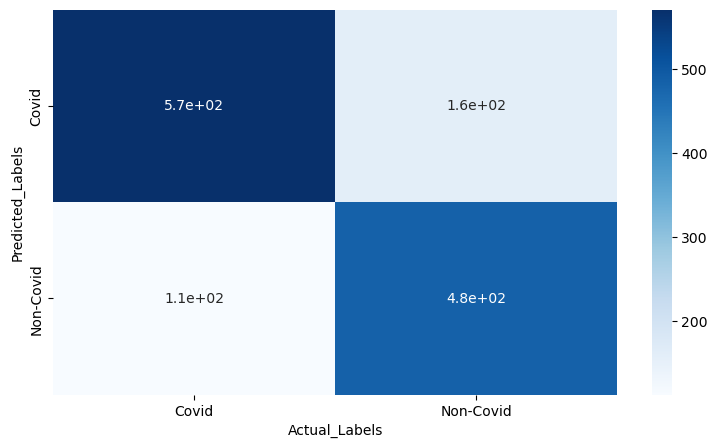

test accuracy = 79.44277108433735%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7944
Precision: 0.7955
Recall: 0.7944
F1 Score: 0.7939


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,X_test_combined,y_test_combined)

In [ ]:
FL-SimpCNN.save('gsm_noniid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 33ms/step


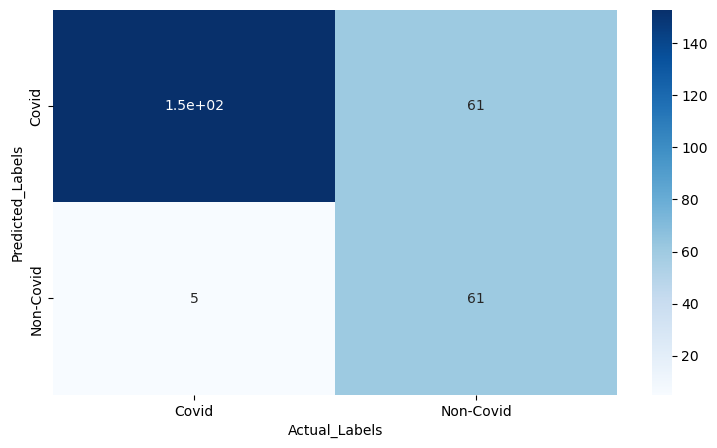

test accuracy = 76.42857142857142%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7643
Precision: 0.8061
Recall: 0.7643
F1 Score: 0.7469
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 1s 29ms/step


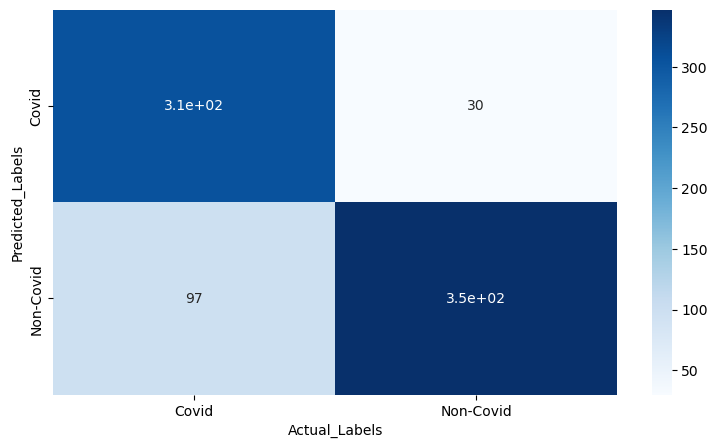

test accuracy = 83.71794871794872%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8372
Precision: 0.8483
Recall: 0.8372
F1 Score: 0.8364
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 41ms/step


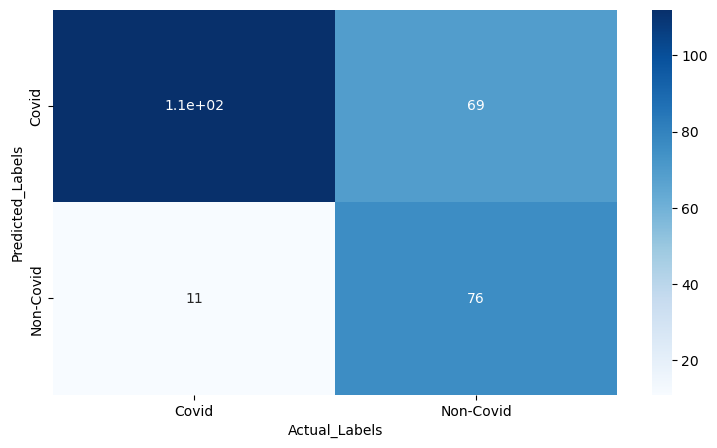

test accuracy = 70.1492537313433%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7015
Precision: 0.7566
Recall: 0.7015
F1 Score: 0.6927


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset3_fed,test_labels_dataset3_fed)

### federated_train_data_nonIID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_balanced)
    FL-SimpCNN = evaluate(server_state,combined_test_data)
    loss = list(FL-SimpCNN.get_metrics_result().values())[0].numpy()
    accuracy = list(FL-SimpCNN.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 1s 17ms/step - loss: 0.6878 - categorical_accuracy: 0.5271


  2%|▉                                           | 1/50 [00:41<34:15, 41.95s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.6691 - categorical_accuracy: 0.6393


  4%|█▊                                          | 2/50 [01:26<34:34, 43.22s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.6412 - categorical_accuracy: 0.7229


  6%|██▋                                         | 3/50 [02:09<34:00, 43.42s/it]

67/67 [==============================] - 1s 14ms/step - loss: 0.6233 - categorical_accuracy: 0.6988


  8%|███▌                                        | 4/50 [02:52<33:02, 43.09s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.6059 - categorical_accuracy: 0.7011


 10%|████▍                                       | 5/50 [03:34<31:58, 42.64s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.5828 - categorical_accuracy: 0.7289


 12%|█████▎                                      | 6/50 [04:17<31:31, 42.98s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5828 - categorical_accuracy: 0.7206


 14%|██████▏                                     | 7/50 [04:57<29:57, 41.80s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5707 - categorical_accuracy: 0.7297


 16%|███████                                     | 8/50 [05:34<28:17, 40.42s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5530 - categorical_accuracy: 0.7417


 18%|███████▉                                    | 9/50 [06:11<26:52, 39.34s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5471 - categorical_accuracy: 0.7462


 20%|████████▌                                  | 10/50 [06:49<26:00, 39.02s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5390 - categorical_accuracy: 0.7470


 22%|█████████▍                                 | 11/50 [07:28<25:17, 38.92s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5347 - categorical_accuracy: 0.7523


 24%|██████████▎                                | 12/50 [08:06<24:22, 38.48s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5343 - categorical_accuracy: 0.7553


 26%|███████████▏                               | 13/50 [08:35<21:58, 35.64s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.5277 - categorical_accuracy: 0.7575


 28%|████████████                               | 14/50 [09:08<21:00, 35.01s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5187 - categorical_accuracy: 0.7643


 30%|████████████▉                              | 15/50 [09:52<21:55, 37.59s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5140 - categorical_accuracy: 0.7583


 32%|█████████████▊                             | 16/50 [10:34<22:04, 38.94s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5109 - categorical_accuracy: 0.7598


 34%|██████████████▌                            | 17/50 [11:16<21:52, 39.77s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.5091 - categorical_accuracy: 0.7711


 36%|███████████████▍                           | 18/50 [11:58<21:42, 40.69s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5121 - categorical_accuracy: 0.7673


 38%|████████████████▎                          | 19/50 [12:42<21:28, 41.56s/it]

67/67 [==============================] - 2s 20ms/step - loss: 0.5100 - categorical_accuracy: 0.7628


 40%|█████████████████▏                         | 20/50 [13:26<21:04, 42.16s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5037 - categorical_accuracy: 0.7711


 42%|██████████████████                         | 21/50 [14:08<20:28, 42.35s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5021 - categorical_accuracy: 0.7703


 44%|██████████████████▉                        | 22/50 [14:48<19:20, 41.43s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5013 - categorical_accuracy: 0.7658


 46%|███████████████████▊                       | 23/50 [15:26<18:17, 40.65s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5006 - categorical_accuracy: 0.7688


 48%|████████████████████▋                      | 24/50 [16:04<17:15, 39.84s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4987 - categorical_accuracy: 0.7733


 50%|█████████████████████▌                     | 25/50 [16:42<16:16, 39.07s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4969 - categorical_accuracy: 0.7748


 52%|██████████████████████▎                    | 26/50 [17:20<15:33, 38.88s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4958 - categorical_accuracy: 0.7741


 54%|███████████████████████▏                   | 27/50 [17:57<14:41, 38.33s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4936 - categorical_accuracy: 0.7756


 56%|████████████████████████                   | 28/50 [18:20<12:19, 33.62s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4914 - categorical_accuracy: 0.7771


 58%|████████████████████████▉                  | 29/50 [19:00<12:29, 35.70s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4893 - categorical_accuracy: 0.7786


 60%|█████████████████████████▊                 | 30/50 [19:43<12:37, 37.85s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4882 - categorical_accuracy: 0.7771


 62%|██████████████████████████▋                | 31/50 [20:28<12:38, 39.90s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4891 - categorical_accuracy: 0.7816


 64%|███████████████████████████▌               | 32/50 [21:11<12:17, 40.95s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4877 - categorical_accuracy: 0.7801


 66%|████████████████████████████▍              | 33/50 [21:54<11:46, 41.59s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4836 - categorical_accuracy: 0.7786


 68%|█████████████████████████████▏             | 34/50 [22:38<11:16, 42.28s/it]

67/67 [==============================] - 2s 21ms/step - loss: 0.4827 - categorical_accuracy: 0.7786


 70%|██████████████████████████████             | 35/50 [23:22<10:42, 42.85s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4816 - categorical_accuracy: 0.7801


 72%|██████████████████████████████▉            | 36/50 [24:01<09:42, 41.59s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4825 - categorical_accuracy: 0.7869


 74%|███████████████████████████████▊           | 37/50 [24:38<08:42, 40.19s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4824 - categorical_accuracy: 0.7861


 76%|████████████████████████████████▋          | 38/50 [25:16<07:53, 39.46s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4802 - categorical_accuracy: 0.7869


 78%|█████████████████████████████████▌         | 39/50 [25:55<07:11, 39.24s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4780 - categorical_accuracy: 0.7877


 80%|██████████████████████████████████▍        | 40/50 [26:33<06:28, 38.86s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4785 - categorical_accuracy: 0.7861


 82%|███████████████████████████████████▎       | 41/50 [27:10<05:44, 38.31s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4774 - categorical_accuracy: 0.7877


 84%|████████████████████████████████████       | 42/50 [27:40<04:47, 35.96s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4780 - categorical_accuracy: 0.7877


 86%|████████████████████████████████████▉      | 43/50 [28:11<04:00, 34.32s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4815 - categorical_accuracy: 0.7877


 88%|█████████████████████████████████████▊     | 44/50 [28:54<03:43, 37.21s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4806 - categorical_accuracy: 0.7877


 90%|██████████████████████████████████████▋    | 45/50 [29:37<03:14, 38.88s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4763 - categorical_accuracy: 0.7929


 92%|███████████████████████████████████████▌   | 46/50 [30:20<02:40, 40.10s/it]

67/67 [==============================] - 2s 17ms/step - loss: 0.4783 - categorical_accuracy: 0.7884


 94%|████████████████████████████████████████▍  | 47/50 [31:05<02:04, 41.58s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4790 - categorical_accuracy: 0.7861


 96%|█████████████████████████████████████████▎ | 48/50 [31:48<01:23, 41.83s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4767 - categorical_accuracy: 0.7877


 98%|██████████████████████████████████████████▏| 49/50 [32:29<00:41, 41.67s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4776 - categorical_accuracy: 0.7892


100%|███████████████████████████████████████████| 50/50 [33:13<00:00, 39.87s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 27ms/step


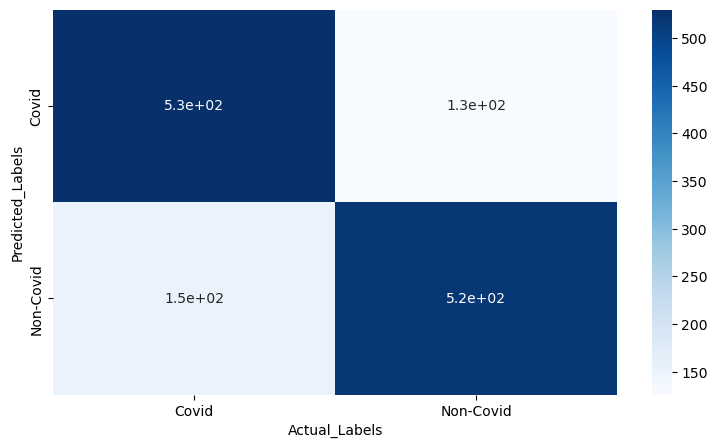

test accuracy = 78.91566265060241%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7892
Precision: 0.7899
Recall: 0.7892
F1 Score: 0.7892


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,X_test_combined,y_test_combined)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 28ms/step


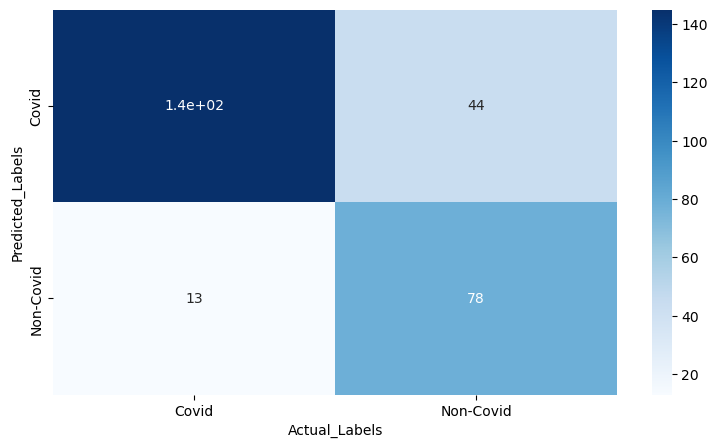

test accuracy = 79.64285714285714%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7964
Precision: 0.8064
Recall: 0.7964
F1 Score: 0.7907
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 1s 28ms/step


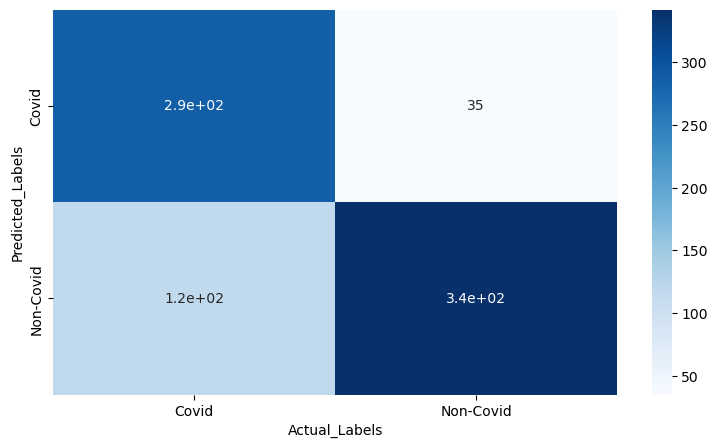

test accuracy = 80.51282051282051%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8051
Precision: 0.8205
Recall: 0.8051
F1 Score: 0.8036
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 25ms/step


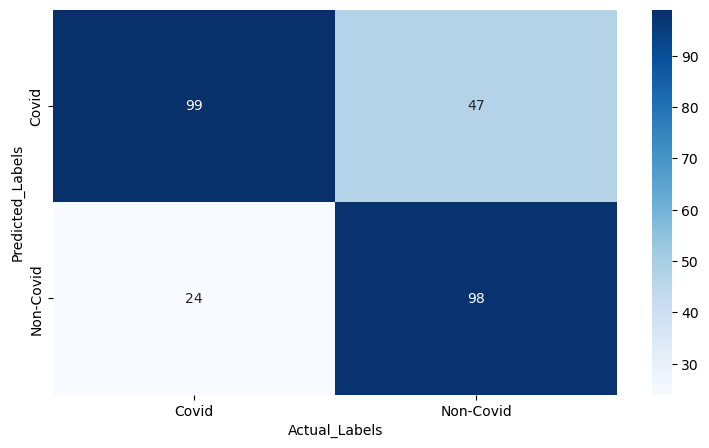

test accuracy = 73.50746268656717%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7351
Precision: 0.7458
Recall: 0.7351
F1 Score: 0.735


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
FL-SimpCNN.save('gsm_noniid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_unbalanced

In [ ]:
X_test_combined_iid = np.concatenate((test_features_dataset1_fed_iid, test_features_dataset2_fed_iid,
                                  test_features_dataset3_fed_iid), axis=0)
y_test_combined_iid = np.concatenate((test_labels_dataset1_fed_iid, test_labels_dataset2_fed_iid,
                                  test_labels_dataset3_fed_iid), axis=0)
test_data_iid = [(X_test_combined_iid,y_test_combined_iid )]
test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
# test_data_iid = [(X_test_combined_iid,y_test_combined_iid)]
# test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
# combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
# combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_unbalanced)
    FL-SimpCNN = evaluate(server_state,combined_test_data_iid)
    loss = list(FL-SimpCNN.get_metrics_result().values())[0].numpy()
    accuracy = list(FL-SimpCNN.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 1s 16ms/step - loss: 0.6651 - categorical_accuracy: 0.6755


  2%|▉                                           | 1/50 [00:55<45:20, 55.52s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.6212 - categorical_accuracy: 0.7033


  4%|█▊                                          | 2/50 [01:50<44:00, 55.01s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5679 - categorical_accuracy: 0.7470


  6%|██▋                                         | 3/50 [02:44<42:46, 54.61s/it]

67/67 [==============================] - 2s 15ms/step - loss: 0.5164 - categorical_accuracy: 0.7952


  8%|███▌                                        | 4/50 [03:40<42:21, 55.24s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4901 - categorical_accuracy: 0.8102


 10%|████▍                                       | 5/50 [04:22<37:43, 50.30s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4776 - categorical_accuracy: 0.8102


 12%|█████▎                                      | 6/50 [05:21<39:16, 53.55s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4705 - categorical_accuracy: 0.8087


 14%|██████▏                                     | 7/50 [06:21<39:48, 55.54s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4692 - categorical_accuracy: 0.8027


 16%|███████                                     | 8/50 [07:23<40:23, 57.70s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4655 - categorical_accuracy: 0.8020


 18%|███████▉                                    | 9/50 [08:26<40:28, 59.23s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.4548 - categorical_accuracy: 0.8042


 20%|████████▌                                  | 10/50 [09:26<39:39, 59.49s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4433 - categorical_accuracy: 0.8072


 22%|█████████▍                                 | 11/50 [10:20<37:32, 57.75s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4326 - categorical_accuracy: 0.8110


 24%|██████████▎                                | 12/50 [11:14<35:51, 56.63s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4225 - categorical_accuracy: 0.8185


 26%|███████████▏                               | 13/50 [12:09<34:39, 56.20s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4178 - categorical_accuracy: 0.8215


 28%|████████████                               | 14/50 [13:02<33:11, 55.31s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4163 - categorical_accuracy: 0.8291


 30%|████████████▉                              | 15/50 [13:42<29:32, 50.63s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.4132 - categorical_accuracy: 0.8261


 32%|█████████████▊                             | 16/50 [14:39<29:49, 52.65s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.4096 - categorical_accuracy: 0.8261


 34%|██████████████▌                            | 17/50 [15:42<30:30, 55.47s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4054 - categorical_accuracy: 0.8306


 36%|███████████████▍                           | 18/50 [16:41<30:13, 56.67s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.3990 - categorical_accuracy: 0.8336


 38%|████████████████▎                          | 19/50 [17:40<29:39, 57.39s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3927 - categorical_accuracy: 0.8426


 40%|█████████████████▏                         | 20/50 [18:42<29:22, 58.75s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3874 - categorical_accuracy: 0.8486


 42%|██████████████████                         | 21/50 [19:39<28:09, 58.27s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3825 - categorical_accuracy: 0.8479


 44%|██████████████████▉                        | 22/50 [20:33<26:33, 56.90s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3789 - categorical_accuracy: 0.8434


 46%|███████████████████▊                       | 23/50 [21:26<25:06, 55.79s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3768 - categorical_accuracy: 0.8419


 48%|████████████████████▋                      | 24/50 [22:21<24:02, 55.48s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3746 - categorical_accuracy: 0.8426


 50%|█████████████████████▌                     | 25/50 [23:09<22:15, 53.43s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3726 - categorical_accuracy: 0.8449


 52%|██████████████████████▎                    | 26/50 [23:56<20:33, 51.41s/it]

67/67 [==============================] - 2s 20ms/step - loss: 0.3710 - categorical_accuracy: 0.8494


 54%|███████████████████████▏                   | 27/50 [24:56<20:40, 53.92s/it]

67/67 [==============================] - 2s 17ms/step - loss: 0.3678 - categorical_accuracy: 0.8539


 56%|████████████████████████                   | 28/50 [26:00<20:52, 56.94s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3636 - categorical_accuracy: 0.8524


 58%|████████████████████████▉                  | 29/50 [27:02<20:27, 58.47s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3602 - categorical_accuracy: 0.8524


 60%|█████████████████████████▊                 | 30/50 [28:04<19:48, 59.43s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3567 - categorical_accuracy: 0.8592


 62%|██████████████████████████▋                | 31/50 [29:04<18:53, 59.64s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3539 - categorical_accuracy: 0.8607


 64%|███████████████████████████▌               | 32/50 [29:59<17:32, 58.46s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3524 - categorical_accuracy: 0.8660


 66%|████████████████████████████▍              | 33/50 [30:55<16:17, 57.48s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3498 - categorical_accuracy: 0.8697


 68%|█████████████████████████████▏             | 34/50 [31:49<15:03, 56.45s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.3466 - categorical_accuracy: 0.8660


 70%|██████████████████████████████             | 35/50 [32:42<13:54, 55.61s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3445 - categorical_accuracy: 0.8667


 72%|██████████████████████████████▉            | 36/50 [33:26<12:07, 52.00s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3426 - categorical_accuracy: 0.8712


 74%|███████████████████████████████▊           | 37/50 [34:27<11:52, 54.83s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3410 - categorical_accuracy: 0.8697


 76%|████████████████████████████████▋          | 38/50 [35:31<11:28, 57.34s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3400 - categorical_accuracy: 0.8705


 78%|█████████████████████████████████▌         | 39/50 [36:32<10:43, 58.48s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3381 - categorical_accuracy: 0.8735


 80%|██████████████████████████████████▍        | 40/50 [37:34<09:55, 59.50s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3359 - categorical_accuracy: 0.8697


 82%|███████████████████████████████████▎       | 41/50 [38:37<09:05, 60.65s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3346 - categorical_accuracy: 0.8682


 84%|████████████████████████████████████       | 42/50 [39:31<07:50, 58.83s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3337 - categorical_accuracy: 0.8690


 86%|████████████████████████████████████▉      | 43/50 [40:26<06:42, 57.51s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3334 - categorical_accuracy: 0.8720


 88%|█████████████████████████████████████▊     | 44/50 [41:22<05:42, 57.14s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3331 - categorical_accuracy: 0.8735


 90%|██████████████████████████████████████▋    | 45/50 [42:18<04:43, 56.77s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3313 - categorical_accuracy: 0.8735


 92%|███████████████████████████████████████▌   | 46/50 [43:00<03:28, 52.18s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.3292 - categorical_accuracy: 0.8690


 94%|████████████████████████████████████████▍  | 47/50 [44:02<02:45, 55.15s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3276 - categorical_accuracy: 0.8712


 96%|█████████████████████████████████████████▎ | 48/50 [45:04<01:54, 57.26s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.3262 - categorical_accuracy: 0.8758


 98%|██████████████████████████████████████████▏| 49/50 [46:07<00:59, 59.17s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3258 - categorical_accuracy: 0.8765


100%|███████████████████████████████████████████| 50/50 [47:10<00:00, 56.61s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 27ms/step


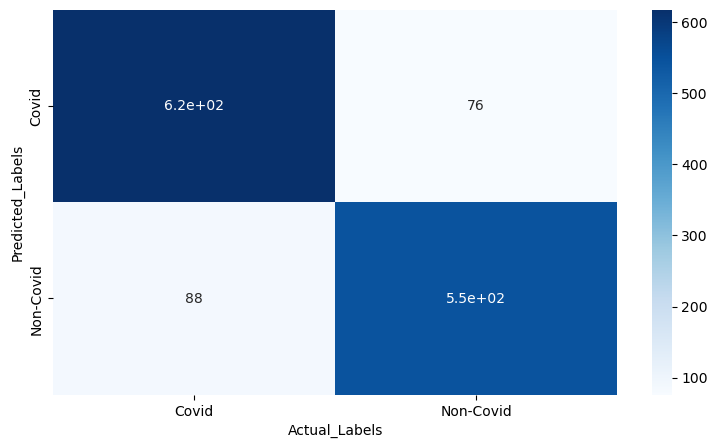

test accuracy = 87.65060240963855%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8765
Precision: 0.8768
Recall: 0.8765
F1 Score: 0.8766


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 25ms/step


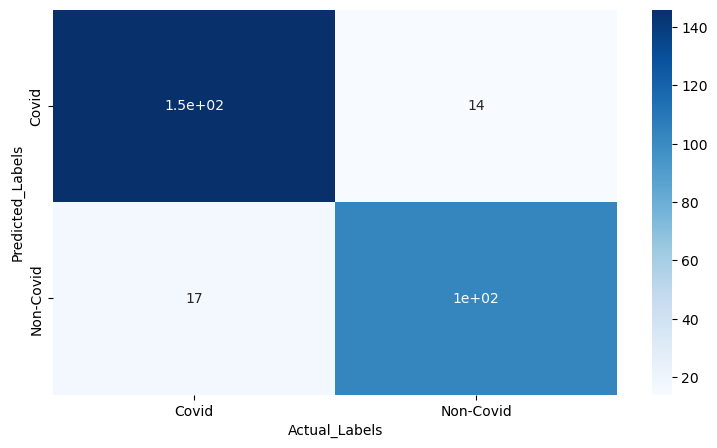

test accuracy = 88.92857142857142%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8893
Precision: 0.8899
Recall: 0.8893
F1 Score: 0.8895
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 1s 25ms/step


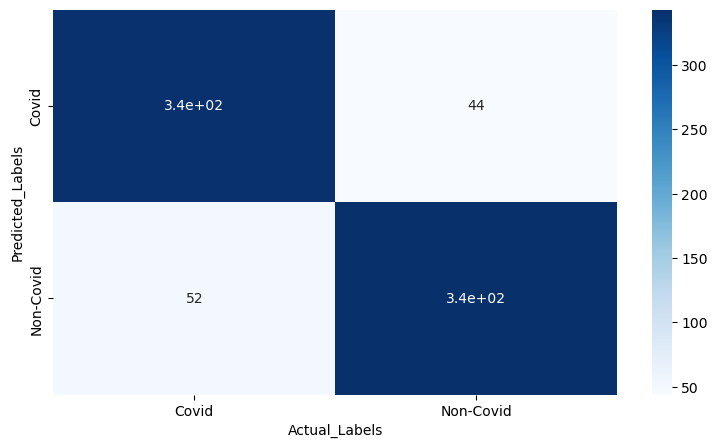

test accuracy = 87.6923076923077%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8769
Precision: 0.8771
Recall: 0.8769
F1 Score: 0.8769
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 36ms/step


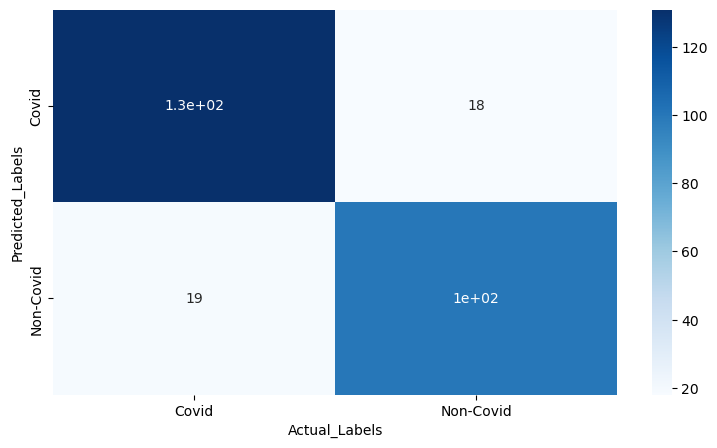

test accuracy = 86.19402985074626%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8619
Precision: 0.8621
Recall: 0.8619
F1 Score: 0.862


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL-SimpCNN.save('gsm_iid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_balanced)
    FL-SimpCNN = evaluate(server_state,combined_test_data_iid)
    loss = list(FL-SimpCNN.get_metrics_result().values())[0].numpy()
    accuracy = list(FL-SimpCNN.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 2s 18ms/step - loss: 0.6768 - categorical_accuracy: 0.6310


  2%|▉                                           | 1/50 [00:42<34:41, 42.49s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.6484 - categorical_accuracy: 0.5896


  4%|█▊                                          | 2/50 [01:22<32:47, 40.99s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.6028 - categorical_accuracy: 0.7297


  6%|██▋                                         | 3/50 [02:01<31:19, 39.99s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.5542 - categorical_accuracy: 0.7952


  8%|███▌                                        | 4/50 [02:39<30:06, 39.27s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.5245 - categorical_accuracy: 0.8087


 10%|████▍                                       | 5/50 [03:17<29:02, 38.72s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.5023 - categorical_accuracy: 0.8102


 12%|█████▎                                      | 6/50 [03:55<28:24, 38.74s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4842 - categorical_accuracy: 0.8087


 14%|██████▏                                     | 7/50 [04:34<27:41, 38.63s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4770 - categorical_accuracy: 0.8072


 16%|███████                                     | 8/50 [04:59<24:08, 34.49s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4703 - categorical_accuracy: 0.8087


 18%|███████▉                                    | 9/50 [05:36<23:57, 35.06s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4665 - categorical_accuracy: 0.8102


 20%|████████▌                                  | 10/50 [06:19<25:08, 37.72s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.4644 - categorical_accuracy: 0.8110


 22%|█████████▍                                 | 11/50 [07:04<25:48, 39.71s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4573 - categorical_accuracy: 0.8110


 24%|██████████▎                                | 12/50 [07:47<25:53, 40.88s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4474 - categorical_accuracy: 0.8110


 26%|███████████▏                               | 13/50 [08:29<25:26, 41.25s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4388 - categorical_accuracy: 0.8110


 28%|████████████                               | 14/50 [09:13<25:13, 42.05s/it]

67/67 [==============================] - 1s 17ms/step - loss: 0.4307 - categorical_accuracy: 0.8140


 30%|████████████▉                              | 15/50 [09:59<25:06, 43.04s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4241 - categorical_accuracy: 0.8193


 32%|█████████████▊                             | 16/50 [10:40<24:06, 42.55s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4203 - categorical_accuracy: 0.8155


 34%|██████████████▌                            | 17/50 [11:17<22:30, 40.92s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4167 - categorical_accuracy: 0.8178


 36%|███████████████▍                           | 18/50 [11:56<21:25, 40.17s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4129 - categorical_accuracy: 0.8208


 38%|████████████████▎                          | 19/50 [12:34<20:31, 39.73s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4104 - categorical_accuracy: 0.8291


 40%|█████████████████▏                         | 20/50 [13:12<19:34, 39.15s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.4080 - categorical_accuracy: 0.8291


 42%|██████████████████                         | 21/50 [13:49<18:40, 38.63s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4048 - categorical_accuracy: 0.8336


 44%|██████████████████▉                        | 22/50 [14:22<17:08, 36.72s/it]

67/67 [==============================] - 2s 20ms/step - loss: 0.4014 - categorical_accuracy: 0.8313


 46%|███████████████████▊                       | 23/50 [14:51<15:34, 34.62s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3973 - categorical_accuracy: 0.8373


 48%|████████████████████▋                      | 24/50 [15:34<16:04, 37.11s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3929 - categorical_accuracy: 0.8389


 50%|█████████████████████▌                     | 25/50 [16:16<16:00, 38.41s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3888 - categorical_accuracy: 0.8456


 52%|██████████████████████▎                    | 26/50 [16:58<15:51, 39.66s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.3853 - categorical_accuracy: 0.8426


 54%|███████████████████████▏                   | 27/50 [17:43<15:43, 41.02s/it]

67/67 [==============================] - 2s 19ms/step - loss: 0.3824 - categorical_accuracy: 0.8426


 56%|████████████████████████                   | 28/50 [18:24<15:04, 41.11s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3802 - categorical_accuracy: 0.8426


 58%|████████████████████████▉                  | 29/50 [19:05<14:24, 41.18s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3783 - categorical_accuracy: 0.8404


 60%|█████████████████████████▊                 | 30/50 [19:49<13:59, 41.99s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3766 - categorical_accuracy: 0.8404


 62%|██████████████████████████▋                | 31/50 [20:29<13:03, 41.26s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3747 - categorical_accuracy: 0.8419


 64%|███████████████████████████▌               | 32/50 [21:06<12:00, 40.02s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3727 - categorical_accuracy: 0.8419


 66%|████████████████████████████▍              | 33/50 [21:43<11:04, 39.07s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3706 - categorical_accuracy: 0.8411


 68%|█████████████████████████████▏             | 34/50 [22:21<10:19, 38.71s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3682 - categorical_accuracy: 0.8419


 70%|██████████████████████████████             | 35/50 [22:59<09:37, 38.51s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3658 - categorical_accuracy: 0.8449


 72%|██████████████████████████████▉            | 36/50 [23:36<08:54, 38.17s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3634 - categorical_accuracy: 0.8494


 74%|███████████████████████████████▊           | 37/50 [24:03<07:34, 34.99s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3611 - categorical_accuracy: 0.8524


 76%|████████████████████████████████▋          | 38/50 [24:39<07:00, 35.02s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.3588 - categorical_accuracy: 0.8562


 78%|█████████████████████████████████▌         | 39/50 [25:22<06:51, 37.43s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3566 - categorical_accuracy: 0.8584


 80%|██████████████████████████████████▍        | 40/50 [26:05<06:30, 39.07s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3544 - categorical_accuracy: 0.8614


 82%|███████████████████████████████████▎       | 41/50 [26:46<05:59, 39.91s/it]

67/67 [==============================] - 2s 18ms/step - loss: 0.3526 - categorical_accuracy: 0.8614


 84%|████████████████████████████████████       | 42/50 [27:31<05:29, 41.17s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3511 - categorical_accuracy: 0.8622


 86%|████████████████████████████████████▉      | 43/50 [28:14<04:53, 41.96s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3498 - categorical_accuracy: 0.8645


 88%|█████████████████████████████████████▊     | 44/50 [28:57<04:13, 42.30s/it]

67/67 [==============================] - 1s 18ms/step - loss: 0.3481 - categorical_accuracy: 0.8660


 90%|██████████████████████████████████████▋    | 45/50 [29:40<03:31, 42.40s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3462 - categorical_accuracy: 0.8682


 92%|███████████████████████████████████████▌   | 46/50 [30:19<02:45, 41.40s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3447 - categorical_accuracy: 0.8667


 94%|████████████████████████████████████████▍  | 47/50 [30:57<02:01, 40.49s/it]

67/67 [==============================] - 1s 15ms/step - loss: 0.3432 - categorical_accuracy: 0.8682


 96%|█████████████████████████████████████████▎ | 48/50 [31:36<01:19, 39.80s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3422 - categorical_accuracy: 0.8682


 98%|██████████████████████████████████████████▏| 49/50 [32:13<00:39, 39.04s/it]

67/67 [==============================] - 1s 16ms/step - loss: 0.3414 - categorical_accuracy: 0.8667


100%|███████████████████████████████████████████| 50/50 [32:51<00:00, 39.44s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 21ms/step


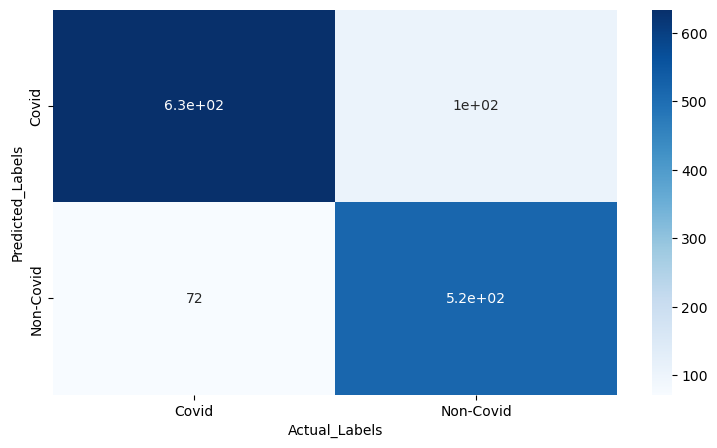

test accuracy = 86.67168674698796%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8667
Precision: 0.8672
Recall: 0.8667
F1 Score: 0.8664


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 25ms/step


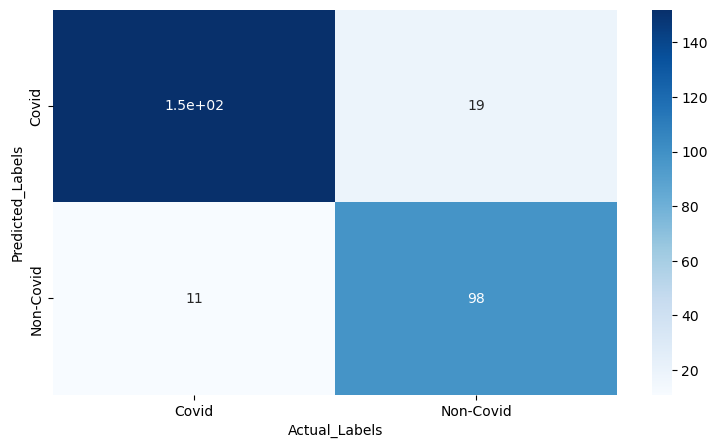

test accuracy = 89.28571428571429%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8929
Precision: 0.8931
Recall: 0.8929
F1 Score: 0.8922
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 1s 25ms/step


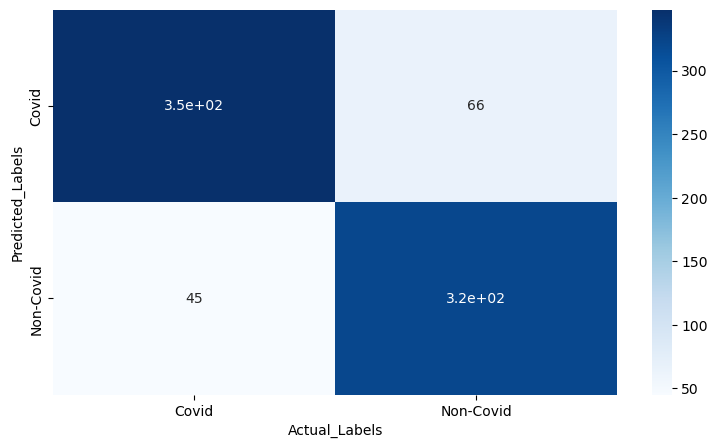

test accuracy = 85.76923076923076%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8577
Precision: 0.8587
Recall: 0.8577
F1 Score: 0.8576
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 23ms/step


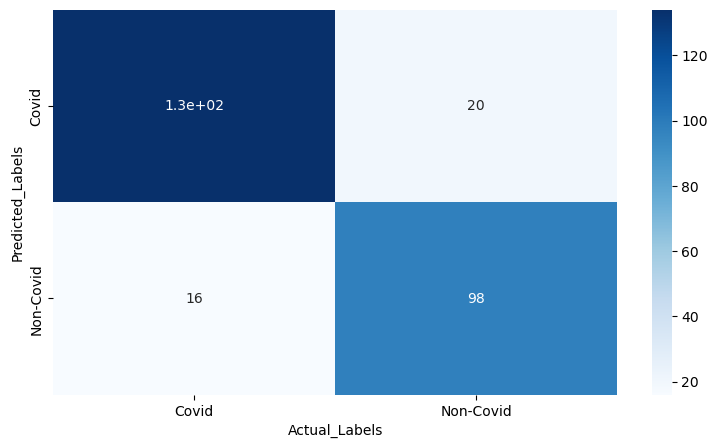

test accuracy = 86.56716417910447%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8657
Precision: 0.8655
Recall: 0.8657
F1 Score: 0.8654


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL-SimpCNN,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL-SimpCNN.save('gsm_iid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
